In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import preprocessing

In [2]:
data = pd.read_csv('accre-gpu-jobs-2022-v2.csv', on_bad_lines='skip')

In [3]:
data

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336945,46754520_26,harovin,porsha,0,5-00:00:00,00:07:07,1,6,1,turing,0:0,RUNNING
336946,46754542,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336947,46754560,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336948,46754598,glasshouse,treva,145.24M,1-00:00:00,00:01:26,1,5,1,turing,0:0,COMPLETED


In [4]:
data = (data[
    (data['STATE']=='COMPLETED') & 
    (data['USEDMEM']!='0') &
    (data['USEDMEM']!='0.00M')])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277475 entries, 0 to 336948
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   JOBID      277475 non-null  object
 1   ACCOUNT    277475 non-null  object
 2   USER       277475 non-null  object
 3   USEDMEM    277475 non-null  object
 4   REQTIME    277475 non-null  object
 5   USEDTIME   277475 non-null  object
 6   NODES      277475 non-null  int64 
 7   CPUS       277475 non-null  int64 
 8   GPUS       277475 non-null  int64 
 9   PARTITION  277475 non-null  object
 10  EXITCODE   277475 non-null  object
 11  STATE      277475 non-null  object
dtypes: int64(3), object(9)
memory usage: 27.5+ MB


In [6]:
def get_seconds(time_str):
    if len(time_str) == 8:
        hh, mm, ss = time_str.split(':')
        return int(hh) * 3600 + int(mm) * 60 + int(ss)
    else: 
        d = time_str[0]
        dropday = time_str[2:]
        hh, mm, ss = dropday.split(':')
        return int(d)*3600*24 + int(hh) * 3600 + int(mm) * 60 + int(ss)

In [7]:
usedtime = data['USEDTIME']
reqtime = data['REQTIME']
usedtime_seconds = []
reqtime_seconds = []

for string in usedtime:
    usedtime_seconds.append(get_seconds(string))
    
for string in reqtime:
    reqtime_seconds.append(get_seconds(string))

In [37]:
data['usedtime_seconds'] = usedtime_seconds
data['reqtime_seconds'] = reqtime_seconds
data['reqtime_days'] = data['reqtime_seconds'] / 86400
data['usedtime_days'] = data['usedtime_seconds'] / 86400
data['reqtime_usedtime_days_diff'] = data['reqtime_days'] - data['usedtime_days']
data.head()

C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\1016221722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['usedtime_seconds'] = usedtime_seconds
C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\1016221722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['reqtime_seconds'] = reqtime_seconds
C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\1016221722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,...,STATE,usedtime_seconds,reqtime_seconds,reqtime_days,usedtime_days,weighted_usedmem,weighted_usedmem_by_GPU,runtime_weighted-GPUS,runtime_per_GPU,reqtime_usedtime_days_diff
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,...,COMPLETED,793,172800,2.000000,0.009178,0.000009,0.000009,4.972154e-07,793,1.990822
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,...,COMPLETED,537,18000,0.208333,0.006215,0.000135,0.000135,3.367020e-07,537,0.202118
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,...,COMPLETED,18586,72000,0.833333,0.215116,0.004867,0.004867,1.165353e-05,18586,0.618218
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,...,COMPLETED,15070,54000,0.625000,0.174421,0.004253,0.004253,9.448974e-06,15070,0.450579
5,32880721,glasshouse,brady,403.40,3-12:00:00,18:49:36,1,1,1,pascal,...,COMPLETED,67776,302400,3.500000,0.784444,0.017143,0.017143,4.249593e-05,67776,2.715556


In [9]:
data['USEDMEM'] = data['USEDMEM'].str.replace('M', '').astype('float')
data['USEDMEM']

C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\3372445554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['USEDMEM'] = data['USEDMEM'].str.replace('M', '').astype('float')


0           18.66
2          402.32
3          417.62
4          450.09
5          403.40
           ...   
336933     137.96
336934    5093.70
336936     156.21
336942    2820.52
336948     145.24
Name: USEDMEM, Length: 277475, dtype: float64

In [10]:
data['weighted_usedmem'] = (data['USEDMEM'] * data['usedtime_seconds']) / data['usedtime_seconds'].sum()
data['weighted_usedmem']

C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\754710002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weighted_usedmem'] = (data['USEDMEM'] * data['usedtime_seconds']) / data['usedtime_seconds'].sum()


0         0.000009
2         0.000135
3         0.004867
4         0.004253
5         0.017143
            ...   
336933    0.000004
336934    0.006678
336936    0.000024
336942    0.001190
336948    0.000008
Name: weighted_usedmem, Length: 277475, dtype: float64

In [11]:
data['weighted_usedmem_by_GPU'] = data['weighted_usedmem'] / data['GPUS']

C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\1363503200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weighted_usedmem_by_GPU'] = data['weighted_usedmem'] / data['GPUS']


In [12]:
data.head()

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,usedtime_seconds,reqtime_seconds,reqtime_days,usedtime_days,weighted_usedmem,weighted_usedmem_by_GPU
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED,793,172800,2.000000,0.009178,0.000009,0.000009
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED,537,18000,0.208333,0.006215,0.000135,0.000135
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED,18586,72000,0.833333,0.215116,0.004867,0.004867
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED,15070,54000,0.625000,0.174421,0.004253,0.004253
5,32880721,glasshouse,brady,403.40,3-12:00:00,18:49:36,1,1,1,pascal,0:0,COMPLETED,67776,302400,3.500000,0.784444,0.017143,0.017143


In [13]:
data['runtime_weighted-GPUS'] = (data['GPUS'] * data['usedtime_seconds']) / data['usedtime_seconds'].sum()
data.head()

C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\553675786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['runtime_weighted-GPUS'] = (data['GPUS'] * data['usedtime_seconds']) / data['usedtime_seconds'].sum()


,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,usedtime_seconds,reqtime_seconds,reqtime_days,usedtime_days,weighted_usedmem,weighted_usedmem_by_GPU,runtime_weighted-GPUS
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED,793,172800,2.000000,0.009178,0.000009,0.000009,4.972154e-07
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED,537,18000,0.208333,0.006215,0.000135,0.000135,3.367020e-07
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED,18586,72000,0.833333,0.215116,0.004867,0.004867,1.165353e-05
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED,15070,54000,0.625000,0.174421,0.004253,0.004253,9.448974e-06
5,32880721,glasshouse,brady,403.40,3-12:00:00,18:49:36,1,1,1,pascal,0:0,COMPLETED,67776,302400,3.500000,0.784444,0.017143,0.017143,4.249593e-05


In [14]:
maxwell = data[data['PARTITION'] == 'maxwell']
pascal = data[data['PARTITION'] == 'pascal']
turing = data[data['PARTITION'] == 'turing']

In [15]:
data_RoCE = data[data['GPUS'] > 4]
data_RoCE_pivoted = data_RoCE.pivot(values = 'GPUS', columns = 'PARTITION')
(data_RoCE_pivoted.notna().sum() / [len(maxwell), len(pascal), len(turing)])

PARTITION
maxwell    0.002122
pascal     0.005696
turing     0.002368
dtype: float64

In [16]:
data['runtime_per_GPU'] = data['GPUS'] * data['usedtime_seconds']

C:\Users\Pupnsuds90\AppData\Local\Temp\ipykernel_19472\2128760150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['runtime_per_GPU'] = data['GPUS'] * data['usedtime_seconds']


In [17]:
(data.groupby('PARTITION')['runtime_per_GPU'].sum() / 60 / 60 / 24 / 365)

PARTITION
maxwell    10.504315
pascal     38.097031
turing     23.272118
Name: runtime_per_GPU, dtype: float64

5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [41]:
maxwell_data = data[data['PARTITION'] == 'maxwell']
pascal_data = data[data['PARTITION'] == 'pascal']
turing_data = data[data['PARTITION'] == 'turing']

In [55]:
maxwell_data['JOBID'].count()

125370

In [56]:
pascal_data['JOBID'].count()

77769

In [57]:
turing_data['JOBID'].count()

74336

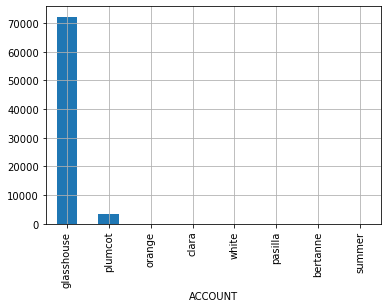

In [92]:
maxwell_data.groupby('ACCOUNT')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False).plot(kind='bar', grid=True);

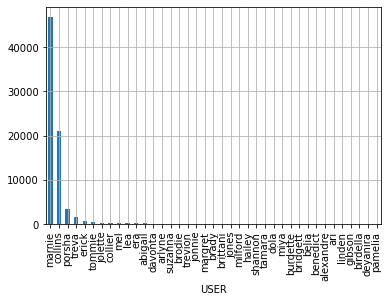

In [102]:
maxwell_data.groupby('USER')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False).plot(kind='bar', grid=True);

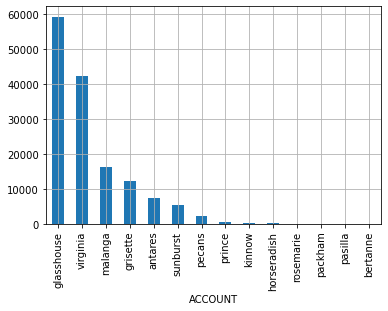

In [93]:
pascal_data.groupby('ACCOUNT')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False).plot(kind='bar', grid=True);

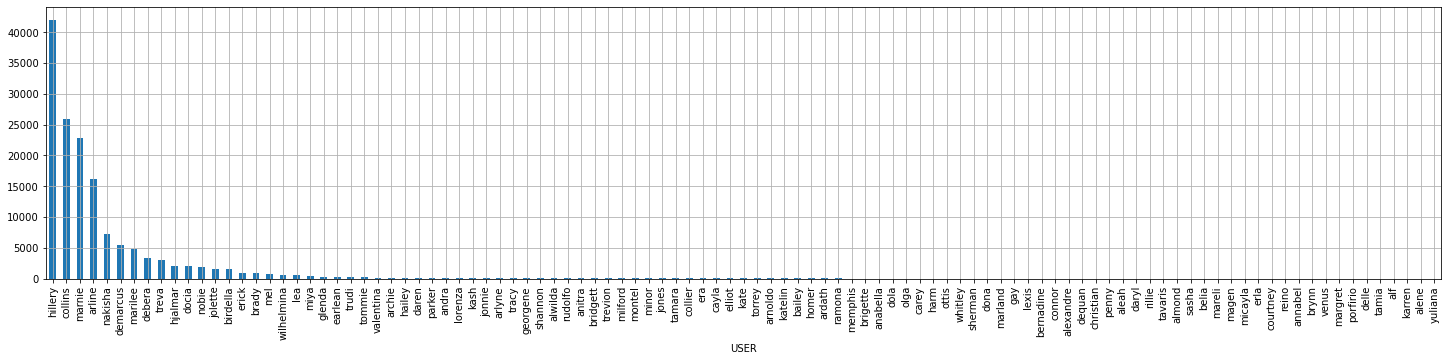

In [109]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
pascal_data.groupby('USER')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False).plot(kind='bar', grid=True);

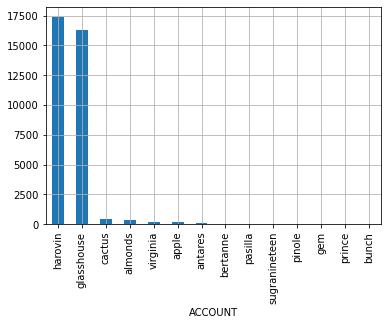

In [94]:
turing_data.groupby('ACCOUNT')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False).plot(kind='bar', grid=True);

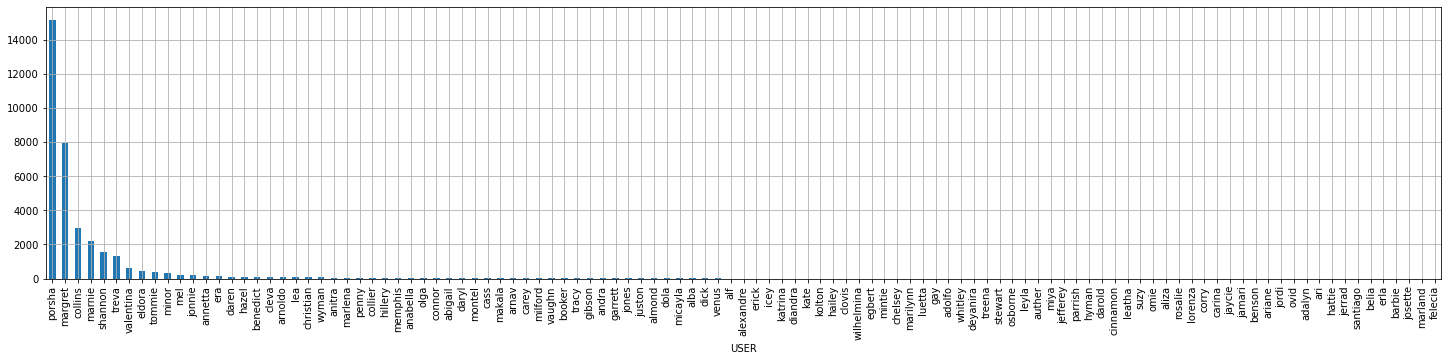

In [111]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
turing_data.groupby('USER')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False).plot(kind='bar', grid=True);

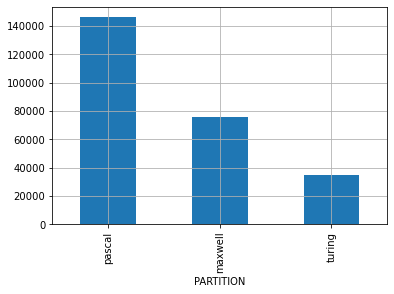

In [87]:
data.groupby('PARTITION')['reqtime_usedtime_days_diff'].sum().sort_values(ascending=False).plot(kind='bar', grid=True);

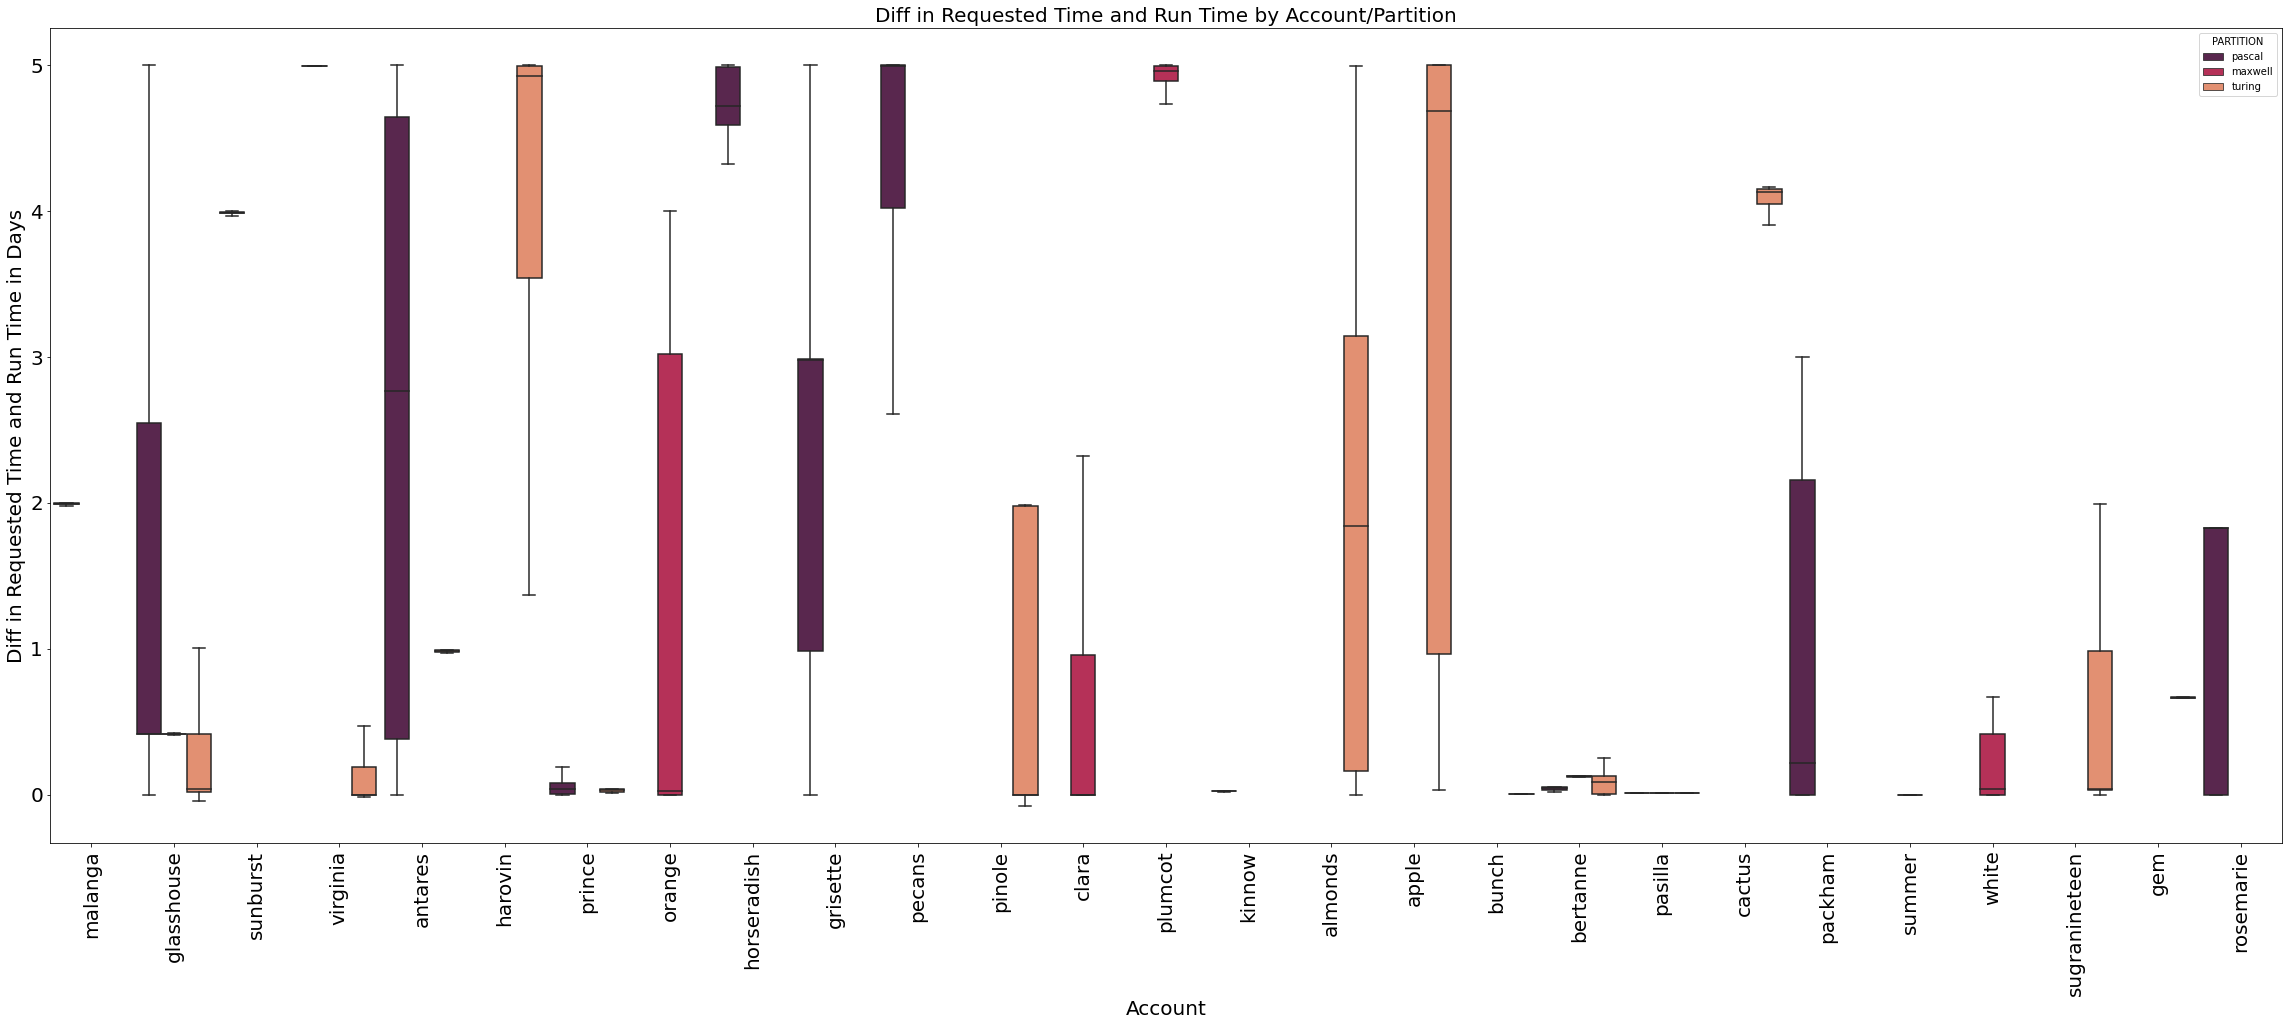

In [91]:
a4_dims = (40, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=data, x = 'ACCOUNT', y="reqtime_usedtime_days_diff", showfliers=False, 
            hue = 'PARTITION', palette = 'rocket', dodge = True, width = .9);
plt.xticks(rotation = 90);
plt.title('Diff in Requested Time and Run Time by Account/Partition', fontsize=20);
plt.xlabel('Account', fontsize=20);
plt.ylabel('Diff in Requested Time and Run Time in Days', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20);

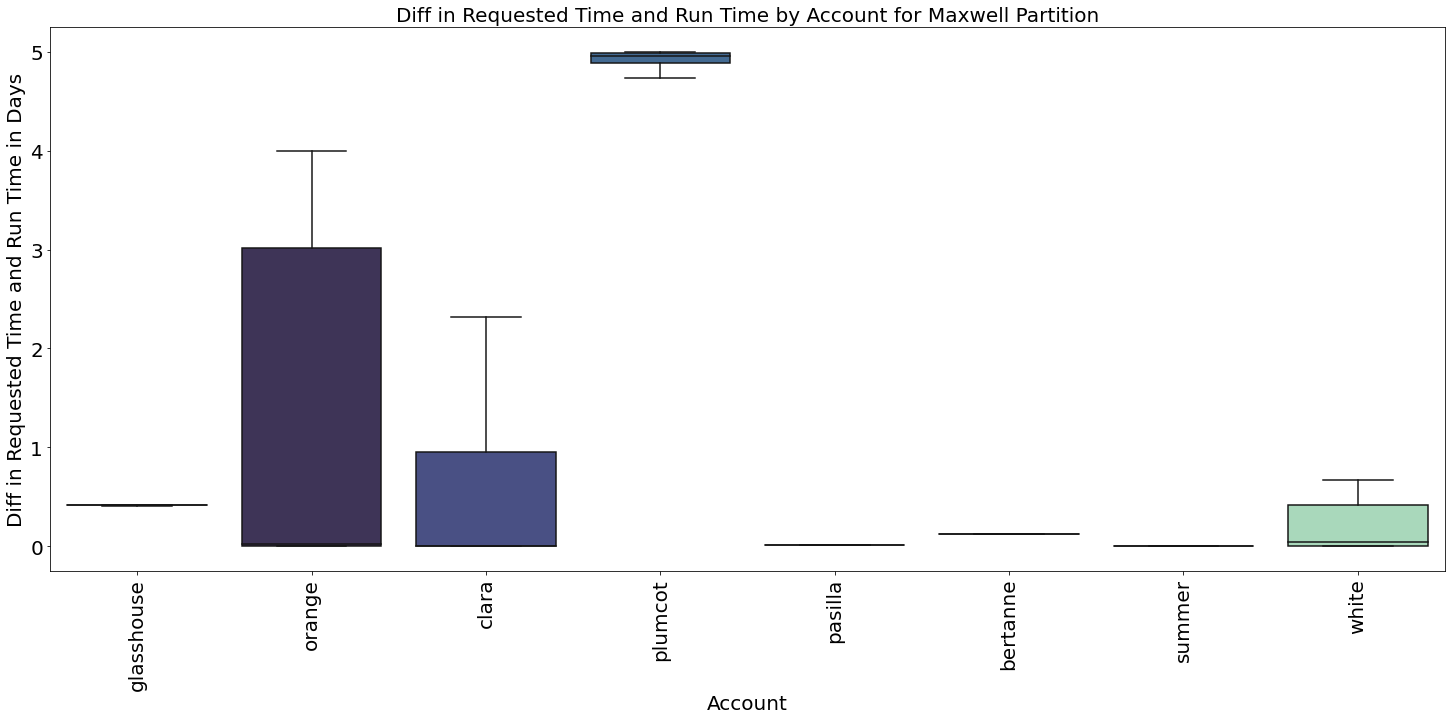

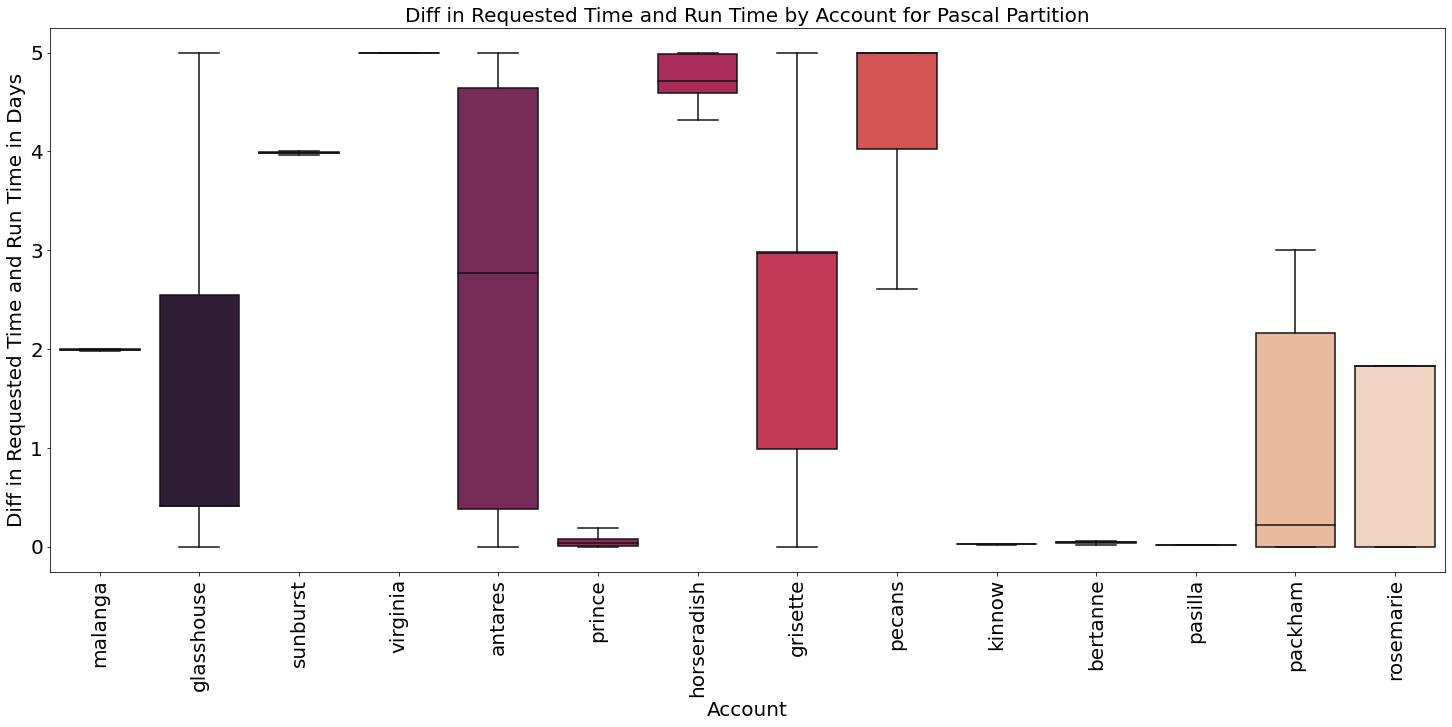

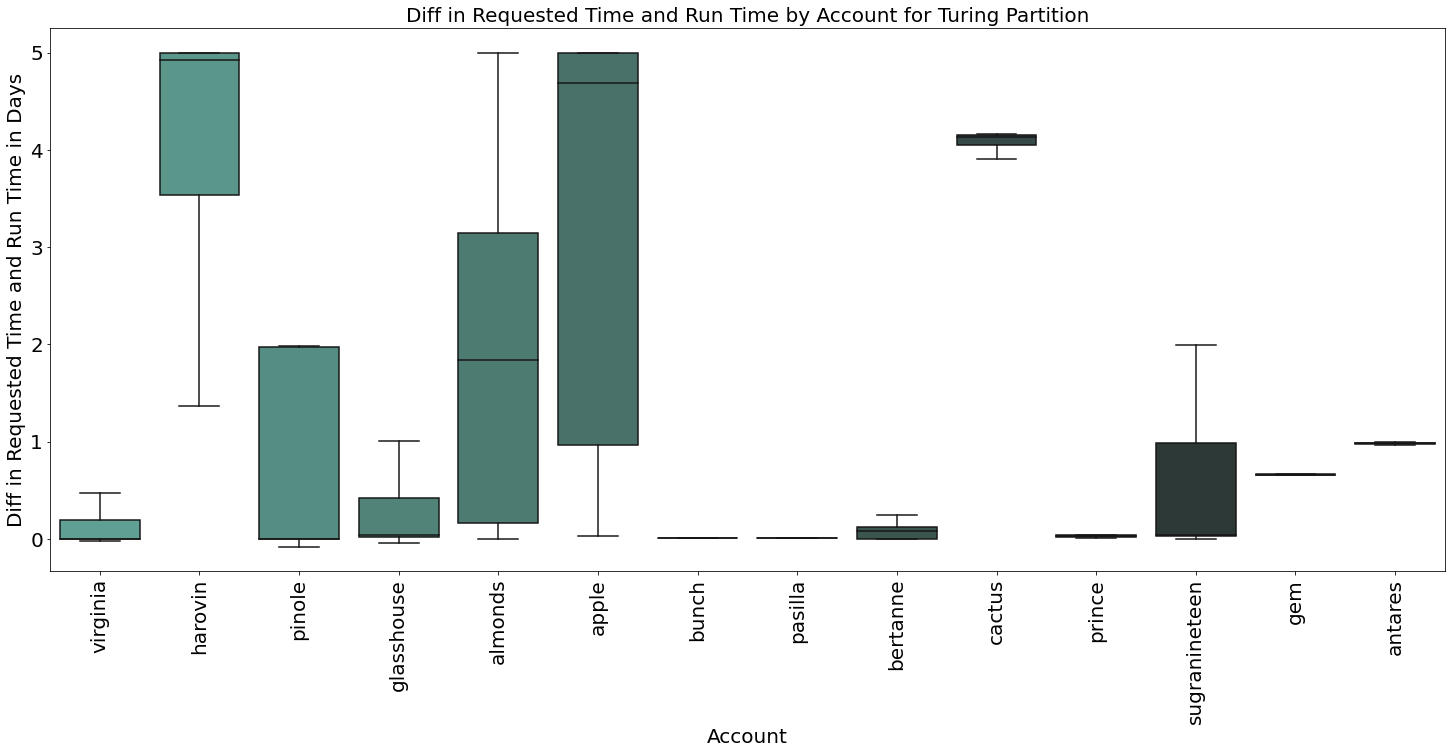

In [100]:
a4_dims = (25, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=maxwell_data, x = 'ACCOUNT', y="reqtime_usedtime_days_diff", showfliers=False, 
            hue = 'ACCOUNT', palette = 'mako', dodge = False, width = 0.8)
plt.legend([],[], frameon=False);
plt.xticks(rotation = 90);
plt.title('Diff in Requested Time and Run Time by Account for Maxwell Partition', fontsize=20);
plt.xlabel('Account', fontsize=20);
plt.ylabel('Diff in Requested Time and Run Time in Days', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20);

a4_dims = (25, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=pascal_data, x = 'ACCOUNT', y="reqtime_usedtime_days_diff", showfliers=False, 
            hue = 'ACCOUNT', palette = 'rocket',dodge = False, width = 0.8)
plt.legend([],[], frameon=False);
plt.xticks(rotation = 90);
plt.title('Diff in Requested Time and Run Time by Account for Pascal Partition', fontsize=20);
plt.xlabel('Account', fontsize=20);
plt.ylabel('Diff in Requested Time and Run Time in Days', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20);

a4_dims = (25, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=turing_data, x = 'ACCOUNT', y="reqtime_usedtime_days_diff", showfliers=False, 
            hue = 'ACCOUNT', palette = 'dark:#5A9_r',dodge = False, width = 0.8)
plt.legend([],[], frameon=False);
plt.xticks(rotation = 90);
plt.title('Diff in Requested Time and Run Time by Account for Turing Partition', fontsize=20);
plt.xlabel('Account', fontsize=20);
plt.ylabel('Diff in Requested Time and Run Time in Days', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20);

In [89]:
data_time_use = data[['USER', 'ACCOUNT', 'reqtime_days', 'usedtime_days', 'reqtime_usedtime_days_diff']]
data_time_use.head()

,USER,ACCOUNT,reqtime_days,usedtime_days,reqtime_usedtime_days_diff
0,arline,malanga,2.000000,0.009178,1.990822
2,brady,glasshouse,0.208333,0.006215,0.202118
3,brady,glasshouse,0.833333,0.215116,0.618218
4,brady,glasshouse,0.625000,0.174421,0.450579
5,brady,glasshouse,3.500000,0.784444,2.715556


In [ ]:
data_time_use.groupby()

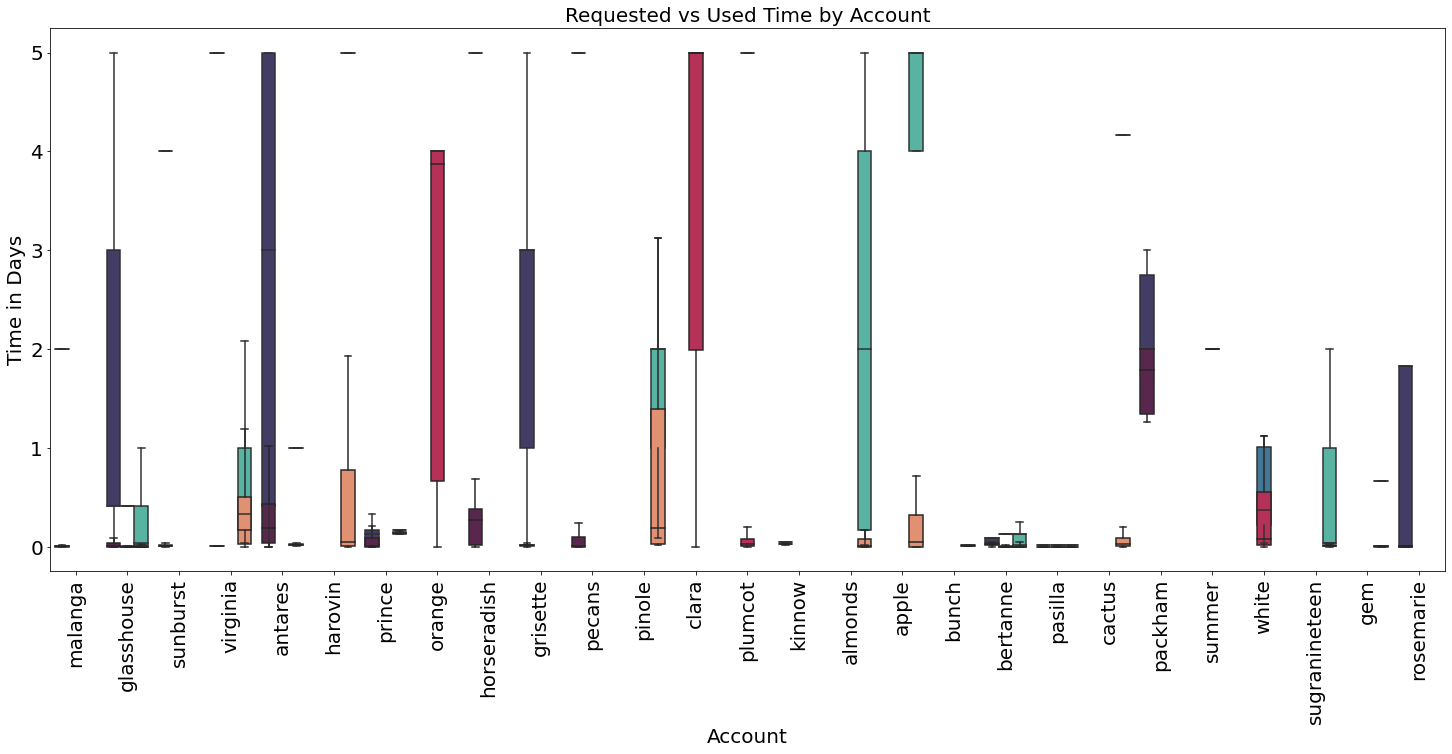

In [98]:
a4_dims = (25, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=data, x = 'ACCOUNT', y="reqtime_days", showfliers=False, 
            hue = 'PARTITION', palette = 'mako',dodge = True, width = 0.8)
sns.boxplot(data=data, x = 'ACCOUNT', y="usedtime_days", showfliers=False, 
            hue = 'PARTITION', palette = 'rocket',dodge = True, width = 0.8)
plt.legend([],[], frameon=False);
plt.xticks(rotation = 90);
plt.title('Requested vs Used Time by Account', fontsize=20);
plt.xlabel('Account', fontsize=20);
plt.ylabel('Time in Days', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20);

In [28]:
data.groupby('ACCOUNT')['reqtime_days'].value_counts(normalize = True)

ACCOUNT  reqtime_days
almonds  2.000000        0.218579
         0.166667        0.213115
         4.000000        0.185792
         3.000000        0.087432
         5.000000        0.081967
                           ...   
white    1.125000        0.066667
         0.208333        0.033333
         0.333333        0.033333
         0.416667        0.033333
         2.333333        0.033333
Name: reqtime_days, Length: 260, dtype: float64

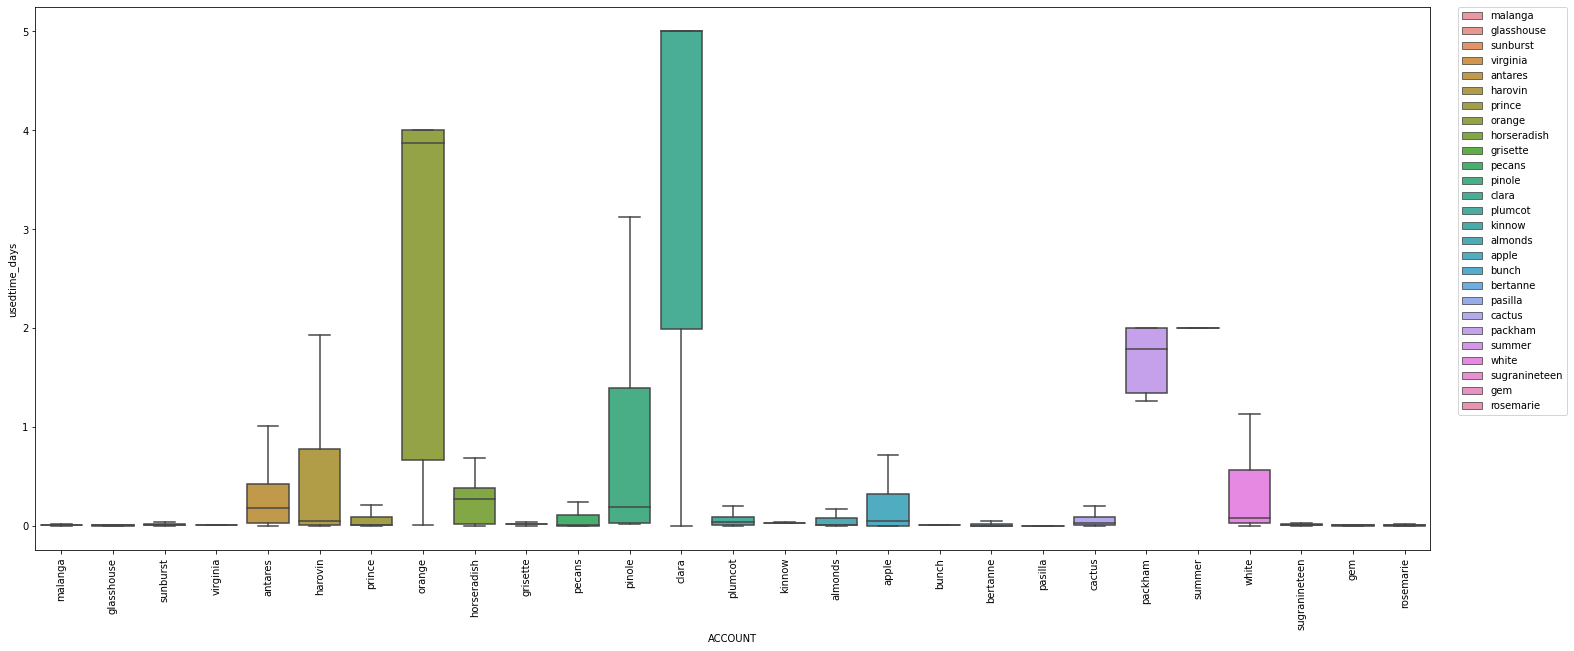

In [20]:
a4_dims = (25,10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(data=data, x = 'ACCOUNT', y="usedtime_days", showfliers=False, hue='ACCOUNT', dodge = False, width = 0.8)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 90);

In [21]:
data.groupby('ACCOUNT')['usedtime_days'].value_counts(normalize = True)

ACCOUNT  usedtime_days
almonds  0.000162         0.016393
         0.000174         0.016393
         0.000185         0.016393
         0.000069         0.010929
         0.000081         0.010929
                            ...   
white    1.800880         0.033333
         2.156713         0.033333
         5.000035         0.033333
         5.000046         0.033333
         5.000243         0.033333
Name: usedtime_days, Length: 29990, dtype: float64

In [24]:
g = sns.FacetGrid(data, col='reqtime_days', row='ACCOUNT')
g.map(sns.histplot, x = 'ACCOUNT')

ValueError: Could not interpret value `ACCOUNT` for parameter `x`